In [1]:
import pandas as pd
import numpy as np
import scipy as sp

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge

import matplotlib.pyplot as plt
%matplotlib inline

## Functions to Relate Conditions to Samples

**Environment**
- A
- B
- C
- D
- E
- F

**Measured**
- W
- X
- Y
- Z

In [2]:
def fW(A, B, C, D, E, F):
    return A * np.random.normal(.3, .1) + E * np.random.normal(.6, .1)

def fX(A, B, C, D, E, F):
    return B * np.random.normal(-1, .1) + A * np.random.normal(-.9, .1) / C

def fY(A, B, C, D, E, F):
    return C * np.random.normal(1.8, .1) + E * np.random.normal(-.3, .1)

def fZ(A, B, C, D, E, F):
    return D * np.random.normal(-0.6, .1) + F**2 * np.random.normal(0.3, .1) + np.sin(A)

## Generate Synthetic Data

In [3]:
columns = ['A', 'B', 'C', 'D', 'E', 'F']
# synthetic environment
N = int(1e4)
A = np.random.uniform(2, 12, N)
B = np.random.uniform(2, 12, N)
C = np.random.uniform(2, 12, N)
D = np.random.uniform(2, 12, N)
E = np.random.uniform(2, 12, N)
F = np.random.uniform(2, 12, N)
G = np.random.uniform(2, 12, N)

# synthetic data
mW = fW(A, B, C, D, E, F)
mX = fX(A, B, C, D, E, F)
mY = fY(A, B, C, D, E, F)
mZ = fZ(A, B, C, D, E, F)

# combine datasets
real = np.vstack([A, B, C, D, E, F]).T
meas = np.vstack([mW, mX, mY, mZ]).T

# add noise to meas
meas *= np.random.normal(1, 0.0001, meas.shape)

## How to have missing numbers in sparse matrix?!

In [4]:
# make dataframe
ad = pd.DataFrame(np.vstack([real.T, meas.T]).T, columns=columns + ['W', 'X', 'Y', 'Z'])

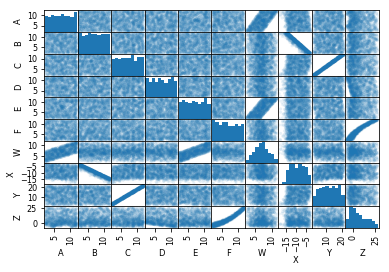

In [5]:
axs = pd.plotting.scatter_matrix(ad.sample(1000), alpha=0.1)

## Make Sparse Matrix

In [6]:
prob_null = 0.2
real[np.random.choice([True, False], real.shape, p=[prob_null, 1-prob_null])] = np.nan
meas[np.random.choice([True, False], meas.shape, p=[prob_null, 1-prob_null])] = np.nan

real = sp.sparse.csr_matrix(real)
meas = sp.sparse.csr_matrix(meas)

In [7]:
rmnan = Imputer()
real = rmnan.fit_transform(real)
meas = rmnan.fit_transform(meas)

## Data Wrangling

In [8]:
# split into test/training
real_train, real_test, meas_train, meas_test = model_selection.train_test_split(real, meas, test_size=0.3)

In [9]:
# create scalers and apply to data
real_scaler = StandardScaler(with_mean=False)
meas_scaler = StandardScaler(with_mean=False)

real_scaler.fit(real_train)
meas_scaler.fit(meas_train)

treal_train = real_scaler.transform(real_train)
tmeas_train = meas_scaler.transform(meas_train)

treal_test = real_scaler.transform(real_test)
tmeas_test = meas_scaler.transform(meas_test)

In [10]:
tmeas_train

<7000x4 sparse matrix of type '<class 'numpy.float64'>'
	with 28000 stored elements in Compressed Sparse Row format>

In [11]:
np.asanyarray(tmeas_train)

array(<7000x4 sparse matrix of type '<class 'numpy.float64'>'
	with 28000 stored elements in Compressed Sparse Row format>, dtype=object)

In [12]:
nn = MLPRegressor((100,100,10), solver='lbfgs', early_stopping=True, activation='tanh')
# nn = KernelRidge(kernel='rbf', alpha=0.1)
nn.fit(tmeas_train, treal_train)

ValueError: input must be a square array

In [67]:
def limcalc(x, pad=0.05):
    rn = np.ptp(x)
    return np.nanmin(x) - rn * pad, np.nanmax(x) + rn * pad

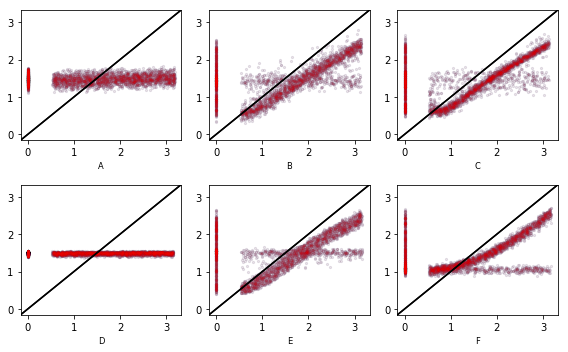

In [68]:
fig, axs = plt.subplots(2, 3, figsize=[8, 5])

# train_predict = real_scaler.inverse_transform(nn.predict(tmeas_train))
# test_predict = real_scaler.inverse_transform(nn.predict(tmeas_test))

# train_meas = real_scaler.inverse_transform(treal_train)
# train_pred = train_predict

# test_meas = real_scaler.inverse_transform(treal_test)
# test_pred = test_predict

train_predict = nn.predict(tmeas_train)
test_predict = nn.predict(tmeas_test)

train_meas = treal_train
train_pred = train_predict

test_meas = treal_test
test_pred = test_predict


# plot training data
for i, (p, ax) in enumerate(zip(columns, axs.flat)):
    ax.set_xlabel(p)
    
    x = test_meas[:, i]
    y = test_pred[:, i]
    
    ax.scatter(x, y, alpha=0.1, s=5)
    
    xt = test_meas[:, i]
    yt = test_pred[:, i]
    ax.scatter(x, y, alpha=0.05, s=5, c='r')
    
    mlim = limcalc(x)
    
    ax.set_xlim(mlim)
    ax.set_ylim(mlim)
    ax.plot(mlim, mlim, c='k')
    
fig.tight_layout()

# plot test data


for i, (p, ax) in enumerate(zip(columns, axs.flat)):
    ax.set_xlabel(p)
    
    mlim = limcalc(x)
    
    ax.set_xlim(mlim)
    ax.set_ylim(mlim)
    ax.plot(mlim, mlim, c='k')
    
fig.tight_layout()